# Assignment Part 1 Brief 

## Deadline: Friday, December 3, 2021 at 15:00 hrs

## Number of marks available for Part 1: 25

## Scope: Sessions 1 to 5

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

A. A **Jupyter Notebook** with the code in all the cells executed and outputs displayed.

B. Name your Notebook **COM4509-6509_Assignment_Part1_Username_XXXXXX.ipynb** where XXXXXX is your username such as such as abc18de.  

C. Upload a .zip file to Blackboard before the deadline that contains the Jupyter Notebook in B and any other files requested for the solution of Part 2 of the Assignment (Dr Lu will be in charge of releasing this part). 

D. **NO DATA UPLOAD**: Please do not upload the data files used in this Notebook. We have a copy already. 


### Assessment Criteria 

* Being able to use numpy and pandas to preprocess a dataset.

* Being able to use numpy to build a machine learning pipeline for supervised learning. 

* Being able to follow the steps involved in an end-to-end project in machine learning.

* Being able to use scikit-learn to design a machine learning model pipeline


### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 5% of the mark each working day the work is late after the deadline. NO late submission will be marked one week after the deadline because we will release a solution by then. Please read [this link](https://sites.google.com/sheffield.ac.uk/comughandbook/general-information/assessment/late-submission) if you are taking COM4509 or read [this link](https://sites.google.com/sheffield.ac.uk/compgtstudenthandbook/menu/assessment/late-submission) if you are taking COM6509. 

### Use of unfair means 

**"Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations."** (from the students Handbook). Please carefully read [this link](https://sites.google.com/sheffield.ac.uk/comughandbook/general-information/assessment/unfair-means) on what constitutes Unfair Means if not sure, for COM4509. If you are taking COM6509, please read [this link](https://sites.google.com/sheffield.ac.uk/compgtstudenthandbook/menu/referencing-unfair-means) if you are not sure what is Unfair means. If you still have questions, please ask your Personal tutor or the Lecturers. 

# A dataset of air quality

The dataset you will use in this assignment comes from a popular machine learning repository that hosts open source datasets for educational and research purposes, the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). We are going to use regularised ridge regression and random forests for predicting air quality. The description of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

In [ ]:
import urllib.request
doq = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
pat_sav = "./AirQualityUCI.zip"
urllib.request.urlretrieve(doq, pat_sav)
#urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip")

('./AirQualityUCI.zip', <http.client.HTTPMessage at 0x7fa720bf9210>)

In [ ]:
import zipfile
zip = zipfile.ZipFile('./AirQualityUCI.zip', 'r')
for name in zip.namelist():
    zip.extract(name, '.')

In [ ]:
# The .csv version of the file has some typing issues, so we use the excel version
import pandas as pd 
air_quality_full = pd.read_excel('./AirQualityUCI.xlsx', usecols=range(2,15))

We can see some of the rows in the dataset 

In [ ]:
air_quality_full.sample(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
1894,1.7,1039.25,-200,12.156068,1055.00,131.0,965.50,117.0,1589.5,844.50,27.975000,23.175000,0.861267
3462,1.9,1141.75,-200,9.132252,944.50,65.0,671.75,68.0,1774.5,798.50,27.324999,57.075000,2.042587
6532,2.4,1194.50,-200,10.963458,1013.00,355.0,645.75,104.0,1344.5,1275.75,14.475000,62.325001,1.021644
2363,0.5,797.50,-200,3.402194,676.50,35.0,1091.50,44.0,1473.0,696.00,20.175000,53.775001,1.256906
4895,6.5,1728.00,-200,35.871083,1683.25,623.0,418.50,188.0,2365.0,1861.00,25.425000,47.925000,1.534608


The target variable corresponds to the CO(GT) variable of the first column. The following columns correspond to the variables in the feature vectors, *e.g.*, PT08.S1(CO) is $x_1$ up until AH which is $x_D$. The original dataset also has a date and a time columns that we are not going to use in this assignment.

### Removing instances 

The dataset has missing values tagged with a -200 value. To simplify the design of the machine learning models in this assignment, we perform the following two operations to the dataset right from the beginning:

* we will remove the rows for which the target variable has missing values. We are doing supervised learning so we need all our data observations to have known target values.

* we will remove features with more than 20% of missing values. 

The code below performs both operations

In [ ]:
# We first remove the rows for which there are missing values in the target feature
air_quality = air_quality_full.loc[air_quality_full.iloc[:, 0]!=-200, :]

In [ ]:
# We now remove the columns (features) for which there are more that 20% of missing values
import numpy as np
ndata, ncols = np.shape(air_quality) # number of data observations and number of columns in the dataframe
pmissing = np.empty(ncols)         # An empty vector that will keep the percentage of missing values per feature
for i in range(ncols):
    pmissing[i] = (air_quality.iloc[:, i]==-200).sum()/ndata # Computes the percentage of missing values per column
air_quality = air_quality.loc[:, pmissing < 0.2]

### Splitting the dataset 

Before designing any machine learning model, we need to set aside the test data. We will use the remaining training data for fitting the model. *It is important to remember that the test data has to be set aside before preprocessing*. 

Any preprocessing that you do has to be done only on the training data and several key statistics need to be saved for the test stage.  Separating the dataset into training and test before any preprocessing has happened help us to recreate the real world scenario where we will deploy our system and for which the data will come without any preprocessing.

Furthermore, we are going to use *hold-out validation* for validating our predictive model so we need to further separate the training data into a training set and a validation set.

We split the dataset into a training set, a validation set and a test set. The training set will have 70% of the total observations, the validation set 15% and the test set, the remaining 15%. For making the random selections of the training and validation sets **make sure that you use a random seed that corresponds to the last five digits of your student UCard**. In the code below, I have used 55555 as an example of my random seed.

In [ ]:
np.random.seed(68744)                 # Make sure you use the last five digits of your student UCard as your seed
index = np.random.permutation(ndata)  # We permute the indexes 
N = np.int64(np.round(0.70*ndata))    # We compute N, the number of training instances
Nval = np.int64(np.round(0.15*ndata)) # We compute Nval, the number of validation instances   
Ntest = ndata - N - Nval              # We compute Ntest, the number of test instances
data_training_unproc = air_quality.iloc[index[0:N], :].copy() # Select the training data
data_val_unproc = air_quality.iloc[index[N:N+Nval], :].copy() # Select the validation data
data_test_unproc = air_quality.iloc[index[N+Nval:ndata], :].copy() # Select the test data
#68744 u card

The assigment is divided into two sections. In the **first section**, you will design a regularised ridge regression model trained with stochastic gradient descent. You will write all the code from scratch. You should not use any library that already implements any of the routines considered in this section, for example, scikit-learn. In the **second section**, you will design a random forests model and you are allowed to use scikit-learn in this section.

When writing your code, you will find out that there are operations that are repeated at least twice. We will assign marks for use of Python functions and for commenting your code. The marks will be assigned as:

* Did you include Python functions to solve the question and avoid repeating code? (**1 mark**)
* Did you comment your code to make it readable to others? (**1 mark**)

# 1. Using regularised ridge regression to predict air quality (10 marks)

**DO NOT USE scikit-learn or any other machine learning library for the questions on this section. You are meant to write Python code from scratch. You can use Pandas and Numpy. Using scikit-learn or any other machine learning library for the questions in this section will give ZERO marks. No excuse will be accepted.**

Regularisation is a technique commonly used in Machine Learning to prevent overfitting. It consists on adding terms to the objective function such that the optimisation procedure avoids solutions that just learn the training data. Popular techniques for regularisation in Supervised Learning include [Lasso Regression](https://en.wikipedia.org/wiki/Lasso_(statistics)), [Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) and the [Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization). 

In this part of the Assignment, you will be looking at Ridge Regression and implementing equations to optimise the objective function using the update rules for stochastic gradient descent. You will use those update rules for making predictions on the Air Quality dataset.

## 1.1 Ridge Regression

Let us start with a data set for training $\mathcal{D} = \{\mathbf{y}, \mathbf{X}\}$, where the vector $\mathbf{y}=[y_1, \cdots, y_N]^{\top}$ and $\mathbf{X}$ is the design matrix from Lab 4, this is, 

\begin{align*}
    \mathbf{X} = 
                \begin{bmatrix}
                        1 & x_{1,1} & \cdots & x_{1, D}\\
                        1 & x_{2,1} & \cdots & x_{2, D}\\
                   \vdots &  \vdots\\
                        1 & x_{N,1} & \cdots & x_{N, D}
                \end{bmatrix}
               = 
               \begin{bmatrix}
                      \mathbf{x}_1^{\top}\\
                       \mathbf{x}_2^{\top}\\
                          \vdots\\
                        \mathbf{x}_N^{\top}
                \end{bmatrix}.
\end{align*}

Our predictive model is going to be a linear model

$$ f(\mathbf{x}_i) = \mathbf{w}^{\top}\mathbf{x}_i,$$

where $\mathbf{w} = [w_0\; w_1\; \cdots \; w_D]^{\top}$.

The **objective function** we are going to use has the following form

$$ E(\mathbf{w}, \lambda) = \frac{1}{N}\sum_{n=1}^N (y_n - f(\mathbf{x}_n))^2 + \frac{\lambda}{2}\sum_{j=0}^D w_j^2,$$

where $\lambda>0$ is known as the *regularisation* parameter.

This objective function was studied in Lecture 4. 

The first term on the rhs is what we call the "fitting" term whereas the second term in the expression is the regularisation term. Given $\lambda$, the two terms in the expression have different purposes. The first term is looking for a value of $\mathbf{w}$ that leads the squared-errors to zero. While doing this, $\mathbf{w}$ can take any value and lead to a solution that it is only good for the training data but perhaps not for the test data. The second term is regularising the behavior of the first term by driving the $\mathbf{w}$ towards zero. By doing this, it restricts the possible set of values that $\mathbf{w}$ might take according to the first term. The value that we use for $\lambda$ will allow a compromise between a value of $\mathbf{w}$ that exactly fits the data (first term) or a value of $\mathbf{w}$ that does not grow too much (second term).

This type of regularisation has different names: ridge regression, Tikhonov regularisation or $\ell_2$ norm regularisation. 

## 1.2 Optimising the objective function with respect to $\mathbf{w}$

There are two ways we can optimise the objective function with respect to $\mathbf{w}$. The first one leads to a closed form expression for $\mathbf{w}$ and the second one using an iterative optimisation procedure that updates the value of $\mathbf{w}$ at each iteration by using the gradient of the objective function with respect to $\mathbf{w}$,
$$
\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} - \eta \frac{d E(\mathbf{w}, \lambda)}{d\mathbf{w}},
$$
where $\eta$ is the *learning rate* parameter and $\frac{d E(\mathbf{w}, \lambda)}{d\mathbf{w}}$ is the gradient of the objective function.

It can be shown (this is a question in the Exercise Sheet 4) that a closed-form expression for the optimal $\mathbf{w}_*$ is given as

\begin{align*}            
            \mathbf{w}_*& = \left(\mathbf{X}^{\top}\mathbf{X} + \frac{\lambda N}   
                                     {2}\mathbf{I}\right)^{-1}\mathbf{X}^{\top}\mathbf{y}.
\end{align*}

Alternatively, we can find an update equation for $\mathbf{w}_{\text{new}}$ using gradient descent leading to:

\begin{align*}
   \mathbf{w}_{\text{new}} & = \mathbf{w}_{\text{old}} - \eta \frac{d E(\mathbf{w}, \lambda)}
                              {d\mathbf{w}},\\
                           & = \mathbf{w}_{\text{old}} +  \frac{2\eta}{N}\sum_{n=1}^N   
                               \left(y_n - \mathbf{x}_n^{\top}\mathbf{w}_{\text{old}}\right)\mathbf{x}_n  
                       - \eta\lambda\mathbf{w}_{\text{old}}\\
                           & = (1 - \eta\lambda)\mathbf{w}_{\text{old}} + \frac{2\eta}
                               {N}\sum_{n=1}^N   
                               \left(y_n - \mathbf{x}_n^{\top}\mathbf{w}_{\text{old}}\right)\mathbf{x}_n
\end{align*}

## 1.3 Preprocessing the data

As mentioned before, the dataset has missing values tagged with a -200 value. Before doing any work with the training data, we want to make sure that we deal properly with the missing values. Furthermore, once we have dealt with the missing values, we want to standardise the training data. 

### Question 1.a: Missing values and standardisation (2 marks)

* For all the other features with missing values, use the mean value of the non-missing values for that feature to perform imputation. Save these mean values, you will need them when performing the validation stage (**1 mark**).

* Once you have imputed the missing data, we need to standardise the input vectors. Standardise the training data by substracting the mean value for each feature and dividing the result by the standard deviation of each feature. Keep the mean values and standard deviations, you will need them at validation time (**1 mark**).

#### Question 1.a Answer

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa720288810>,
      dtype=object)

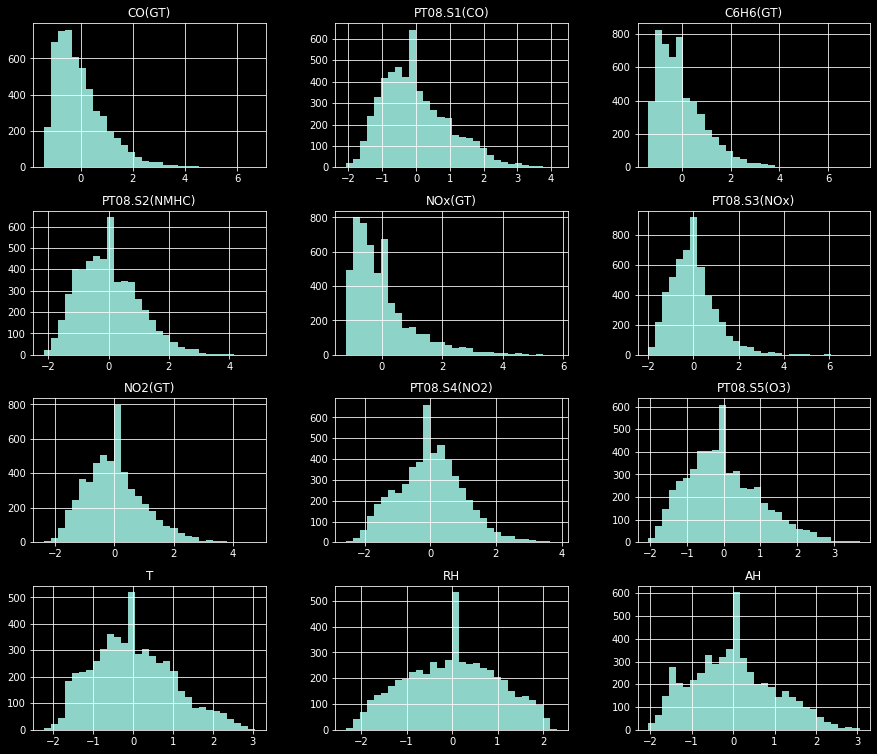

In [ ]:
pl_hld = pd.DataFrame(columns = data_training_unproc.columns)

for i in data_training_unproc:
  # Need a temporary data set with all the non-missing values from the training dataset
  plhld_var = data_training_unproc[data_training_unproc[i]!=-200]
  pl_hld[i] = plhld_var[i]

#Calculate the mean of all values inside the placeholder
cmean = pl_hld.mean()


#imputation
# overwrite the missing values in the training dataset with the means
train_replace = data_training_unproc.replace(-200, cmean)

#Calculate the standard deviation of every value inside the training dataset
standard_dev = train_replace.std()

#STANDARDIZATION of training data
train_dataset = (train_replace - cmean)/standard_dev


#SANITY CHECK# Make sure that the notebook displays the plot properly
%matplotlib inline
from matplotlib import pyplot
pyplot.style.use('dark_background')
train_dataset.hist(bins=30, figsize=(15, 13))

## 1.4 Training and validation stages

We have now curated our training data by removing data observations and features with a large amount of missing values. We have also normalised the feature vectors. We are now in a good position to work on developing the prediction model and validating it. We will use gradient descent for iterative optimisation. 

We first organise the dataframe into the vector of targets $\mathbf{y}$, call it `yTrain`, and the design matrix $\mathbf{X}$, call it `XTrain`.

In [ ]:
#Training Dataset separated into design model xTrain, from column PT08.S1(CO) all the way to the last column (AH)
xTrain = pd.DataFrame(train_dataset.iloc[:, 1:train_dataset.last_valid_index()])

#For yTrain we need to reverse the standardization, otherwise it will affect the computation of w, using minibatch gradient descent.
NoStan_train = train_dataset*standard_dev


#Training Dataset separated into the vector of targets y, called yTrain. take the first column CO(GT)
yTrain = pd.DataFrame(NoStan_train.iloc[:, 0])


print(xTrain)
print(yTrain)

      PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  ...         T        RH        AH
1097    -1.165636 -1.032958      -1.201617  ... -0.060000 -0.829593 -0.787680
2756    -1.006900 -0.570714      -0.500915  ...  2.261076 -1.947816  0.032375
3479    -0.287917  0.358418       0.512274  ...  2.198034 -1.548763  1.026382
6798     0.483589  0.720063       0.840099  ... -1.128841 -0.594254 -1.461240
3764    -1.310367 -0.943068      -1.044414  ...  1.960196 -1.443519  0.895207
...           ...       ...            ...  ...       ...       ...       ...
9344    -0.933367 -1.201460      -1.549571  ... -0.641702  0.418724 -0.496819
5636    -0.234226 -0.378473      -0.262236  ...  0.601936  0.965411  2.115502
8767    -0.395297 -0.755668      -0.753973  ... -1.243462 -0.250748 -1.380082
4574    -0.353279 -0.089026       0.063672  ...  0.229418  0.503504  0.828326
6776    -0.119843 -0.709240      -0.687833  ... -0.610181  1.440472  0.179590

[5372 rows x 11 columns]
        CO(GT)
1097 -1.259661
2756 -1.

### Question 1.b: finding the optimal $\mathbf{w}$ with stochastic gradient descent (3 marks)

Use gradient descent to iteratively compute the value of $\mathbf{w}_{\text{new}}$. Instead of using all the training set in `XTrain` and `yTrain` to compute the gradient, use a subset of $S$ instances in `XTrain` and `yTrain`. This is sometimes called *minibatch gradient descent* where $S$ is the size of the minibacth. When using gradient descent with minibatches, you need to find the best values for three parameters: $\eta$, the learning rate, $S$, the number of datapoints in the minibatch and $\gamma$, the regularisation parameter.

* In this question we will use the validation data. So before proceeding to the next steps, make sure that you:  replace the missing values on each feature variables with the mean value you computed with the training data; standardise the validation data using the means and standard deviations computed from the training data (**1 mark**).
    
* Create a grid of values for the parameters $\gamma$ and $\eta$ using `np.logspace` and a grid of values for $S$ using `np.linspace`. Because you need to find three parameters, start with five values for each parameter in the grid and see if you can increase it. Make sure you understand what is the meaning of `np.logspace` and `np.linspace`. Notice that you can use negative values for `start` in `np.logspace` (**1 mark**).

* For each value that you have of $\gamma$, $\eta$ and $S$ from the previous step, use the training set to compute $\mathbf{w}$ using minibatch gradient descent and then measure the RMSE over the validation data. For the validation data, make sure you preprocess it before applying the prediction model over it. For the minibatch gradient descent choose to stop the iterative procedure after $200$ iterations (**1 mark**).

* Choose the values of $\gamma$, $\eta$ and $S$ that lead to the lowest RMSE and save them. You will use them at the test stage.

#### Question 1.b Answer

In [ ]:
# replace the missing values on each feature variables with the mean value you computed with the training data

#standardise the validation data using the means and standard deviations computed from the training data

#VALIDATION DATA
val_replace = data_val_unproc.replace(-200, cmean)

Val_dataset = (val_replace - cmean)/standard_dev

#Validation Dataset separated into design model xTrain, from column PT08.S1(CO) all the way to the last column (AH)
xVal = pd.DataFrame(Val_dataset.iloc[:, 1:Val_dataset.last_valid_index()])

#For yVal we need to reverse the standardization, otherwise it will affect the computation of w, using minibatch gradient descent.
NoStan_Val = Val_dataset*standard_dev

#Validation Dataset separated into the vector of targets y, called yTrain. take the first column CO(GT)
yVal = pd.DataFrame(NoStan_Val.iloc[:, 0])



#find 3 param γ, η and S, each must have at least 5 in the grid

  #np.logspace => γ, η
γ_log = np.logspace(-13.0,
               -12.0,
               num = 5,
               endpoint = True,
               base = 2.0,
               dtype = None)

print("γ_log\n", γ_log,'\n')

# 3.0,               4.0,
η_log = np.logspace(-8.0,
                    -7.0,
               num = 5,
               endpoint = True,
               base = 2.0,
               dtype = None)

print("η_log\n", η_log, '\n')

  #np.linspace => S

S_lin = np.linspace(95,
                    100,
               num = 5,
               endpoint = True,
               retstep = False,
               dtype = int)

print('S_lin\n', S_lin)

#S is the size of the minibacth.
# When using gradient descent with minibatches, you need to find the best values for three parameters:
 # η, the learning rate, 
 # S, the number of datapoints in the minibatch 
 # and γ, the regularisation parameter.


# linear regression using "mini-batch" gradient descent
# Compute hypothesis / predictions
def hypothesis(X, theta):
    return np.dot(X, theta)

  
# Compute gradient of error function w.r.t. theta
def gradient(X, y, theta):
    h = hypothesis(X, theta)
    grad = np.dot(X.transpose(), (h - y))
   
    return grad

#Cost function for ridge regression 
def cost_Reg(X,y,theta,lmd):
    m = len(y) 
    h = hypothesis(X, theta)
    J_reg = (lmd / (2*m)) * np.sum(np.square(theta))
    J = float((1./(2*m)) * np.dot((h - y).transpose(), (h - y))) + J_reg
    
    return J 

#Create a list containing randomized mini-batches
# For the minibatch gradient descent choose to stop the iterative procedure after 200 iterations
def create_mini_batches(X, y, batch_size):
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
  
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches
   
  
#Calculate mini-batch Gradient descent for ridge regression
def gradient_descent_reg(X,y,learning_rate,lmd, batch_size):
    m = np.size(y)
    theta = np.zeros((X.shape[1], 1))
    nr_iters = 200
    errors = []

    for itr in range(nr_iters):
        mini_batches = create_mini_batches(X, y, batch_size)

        for mini_batch in mini_batches:
            X_mini, y_mini = mini_batch
            theta = theta - learning_rate *(1/m)* (gradient(X, y, theta) + lmd * theta) 
            errors.append(cost_Reg(X_mini, y_mini, theta, lmd))
            
    return theta ,errors


#Replace learning rate n and batch size S for every version and the other variables



 # η, is the learning rate, 
 # S, the number of datapoints in the minibatch (batch size) 
 # and γ, the regularisation parameter.

# Will need to use this again, better to have it defined as a function 
def Find_RMSE(x,y, x_v, y_v):
  RMSE = 10000
#Loop this for all batch_size,learning_rate ,lmd values
#make a function for later use
  for j in η_log:
    for t in S_lin:
      for i in γ_log:


        print('\nη_log is: ', j,'\nS_lin is: ', t,'\nγ_log is: ', i)
        # learning_rate = j
        # batch_size = t
        # lambda = i
      
        #Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients
        theta, errors = gradient_descent_reg(x, y,j, i,t)


        print("\nBias = ", theta[0])
        print("\nCoefficients = ", theta[1:])

    
        y_pred = hypothesis(x_v, theta)


        #Compute the w of the ridge regression, using the training set
     
        n, m = x.shape
        I = np.identity(m)
        w = np.dot(np.dot(np.linalg.inv(np.dot(x.transpose(), x) + i * I), x.transpose()), y)

        print('\nw is :',w)

        # Measure the RMSE over the validation data
        temp_RMSE = float(np.sqrt(np.mean((y_v   - y_pred)**2)))

        #Store the smallest value of RMSE and save the 
        if RMSE > temp_RMSE:
          RMSE = temp_RMSE
          γ_log_sol = i
          η_log_sol = j
          S_lin_sol = t

          print('\nTemporary finds: ', RMSE,' ', γ_log_sol, ' ',η_log_sol, ' ',S_lin_sol)

  return RMSE,γ_log_sol, η_log_sol, S_lin_sol

#IV#
#Choose the values of γ, η and S that lead to the lowest RMSE and save them. You will use them at the test stage.

RMSE,γ_log_sol,η_log_sol,S_lin_sol= Find_RMSE(xTrain, yTrain, xVal, yVal)

print("\nRoot Mean Square Error = ", RMSE)
print('\nVariable η_log is: ', η_log_sol,'\nnVariable S_lin is: ', S_lin_sol,'\nnVariable γ_log is: ', γ_log_sol)

## 1.5 Test stage 

We now know which one is the best model, according to the validation data. We will now put together the training data and the validation data, perform the preprocessing as we did before, this is, treat the missing values and standardise the inputs. We will train the model again using the minibatch stochastic gradient descent and finally compute the RMSE over the test data.


### Question 1.c: combine the original training and original validation data and perform the preprocessing again to this new data (2 marks)

Put together the original training and validation dataset and perform the same preprocessing steps than before, these are: 

* for each feature, impute the missing values with the mean values of the non-missing values (**1 mark**) 

* stardardise the new training set (**1 mark**).

#### Question 1.c Answer

In [ ]:


# Training_unprocesed + Validation_unprocesed dataset
new_data = [data_val_unproc, data_training_unproc]
  
new_unproc_train = pd.concat(new_data)
display(new_unproc_train)

#Calculate the means of the non-missing values
pl_hld_2 = pd.DataFrame(columns = new_unproc_train.columns)

for i in new_unproc_train:
  # Need a temporary data set with all the non-missing values from the new training dataset
  plhld_var_2 = new_unproc_train[new_unproc_train[i]!=-200]
  pl_hld_2[i] = plhld_var_2[i]

#Calculate the mean of all values inside the placeholder
new_mean = pl_hld_2.mean()

#Calculate the standard deviation
standard_dev_2 = new_unproc_train.std()

#Replace missing values with the mean values of the non-missing values
new_replace = new_unproc_train.replace(-200, new_mean)

#Standardise the new training set
new_train_dataset = (new_replace - new_mean)/standard_dev_2


#New Testing Dataset separated into the vector of targets y, called x_newTrain. take the first column CO(GT)
x_newTrain = pd.DataFrame(new_train_dataset.iloc[:, 1:new_train_dataset.last_valid_index()])

#New Testing Dataset separated into the vector of targets y, called y_newTrain. take the first column CO(GT)
y_newTrain = pd.DataFrame(new_train_dataset.iloc[:, 0])


### Question 1.d: Preprocess the test data, train the model and predict over the test data (3 marks)

Preprocess the test data and train a new model using the new training set. Finally, report the RMSE over the test set:

* Preprocess the test data by imputing the missing data and standardising it (**1 mark**). 

* Use the best values of $\gamma$, $\eta$ and $S$ found in the validation set and train a new regularised linear model with stochastic gradient descent (**1 mark**).

* Report the RMSE over the test data (**1 mark**).

#### Question 1.d Answer

In [ ]:
# Write your code here

# Preprocess TEST DATA

#Calculate the means of the non-missing values
pl_hld_3 = pd.DataFrame(columns = data_test_unproc.columns)

for i in new_unproc_train:
  # Need a temporary data set with all the non-missing values from the test dataset
  plhld_var_3 = data_test_unproc[data_test_unproc[i]!=-200]
  pl_hld_3[i] = plhld_var_3[i]

#Calculate the mean of all values inside the placeholder
tmean = pl_hld_3.mean()

#Calculate the standard deviation
standard_dev_3 = data_test_unproc.std()

#Replace missing values with the mean values of the non-missing values
data_test_unproc = data_test_unproc.replace(-200, tmean)

#Standardise the new testing set
TST_dataset = (data_test_unproc - tmean)/standard_dev_3


 x_Test = pd.DataFrame(TST_dataset.iloc[:, 1:TST_dataset.last_valid_index()])

# New Testing Dataset separated into the vector of targets y, called y_newTrain. take the first column CO(GT)
 y_Test = pd.DataFrame(TST_dataset.iloc[:, 0])


#Preprocess the test data and train a new model using the new training set


#apply method



new_RMSE,new_γ_log_sol,new_η_log_sol,new_S_lin_sol= Find_RMSE(x_newTrain, y_newTrain, x_Test,y_Test)

print("\nRoot Mean Square Error = ", new_RMSE)
print('\nVariable η_log is: ', new_η_log_sol,'\nnVariable S_lin is: ', new_S_lin_sol,'\nnVariable γ_log is: ', new_γ_log_sol)


#Use the best γ, η and S found in the validation set for the stochastic gradient descent 
#display(TST_dataset)
# Calculate the RMSE over the test data



# 2. Random forests (13 marks)

**USE scikit-learn for the questions on this section.**

In section 1, you used a regularised ridge regression model trained with SGD to create a linear predictive model. In this part of the assignment, you will use **scikit-learn** to train a random forest for regression over the air quality dataset.

## 2.1 Preprocessing the data

As mentioned before, the dataset has missing values tagged with a -200 value. Before doing any work with the training data, we want to make sure that we deal properly with the missing values. Furthermore, once we have dealt with the missing values, we want to standardise the training data. 

### Question 2.a: Pipeline for missing values and standardisation (3 marks)

* Employ the `SimpleImputer` method in Scikit-learn to impute the missing values in each column using the mean value of the non-missing values, instead (**1 mark**).

* Standardise the data by substracting the mean value for each feature and dividing the result by the standard deviation of each feature. Employ the `StandardScaler` method (**1 mark**).

* Create a `Pipeline` that you can use to preprocess the data by filling missing values and then standardising the features (**1 mark**).

#### Question 2.a Answer

In [ ]:

# Fit method calculates mean and std on whichever the dataset you choose,
# and transform applies the transofrmation with the computed values by the fit.

# Importing the SimpleImputer class from sklearn
from sklearn.impute import SimpleImputer

# Initializing the SimpleImputer object with missing_value and strategy defined
imp_mean = SimpleImputer(missing_values = -200, strategy='mean')

# Fitting the SimpleImputer using the trainning data set
imp_mean.fit(data_training_unproc)

# Filling in the missing values in data_training_unproc using the fitted SimpleImputer
si_train = imp_mean.transform(data_training_unproc)

#Standardise the data by substracting the mean value for each feature and dividing the result by the standard deviation of each feature. 
#Employ the StandardScaler method.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
 

# call estimator1.fit_transform(x_train) you compute mean and std on x_train_(and store them) and standarize _x_train. 

si_train_std=pd.DataFrame(scaler.fit_transform(si_train))

# Name the columns
si_train_std.columns=train_dataset.columns

print('\n', si_train_std)

print(si_train_std is train_dataset)

from sklearn.pipeline import Pipeline

pl_pipe = Pipeline([('imputer',SimpleImputer(missing_values = -200, strategy='mean')), ('scaler', StandardScaler())])

# fit and then transform 
train_pipe = pd.DataFrame(pl_pipe.fit_transform(data_training_unproc))


print('\n', train_pipe)


         CO(GT)  PT08.S1(CO)  C6H6(GT)  ...         T        RH        AH
0    -0.865286    -1.165745 -1.033054  ... -0.060006 -0.829670 -0.787753
1    -0.933978    -1.006994 -0.570767  ...  2.261286 -1.947997  0.032378
2    -0.178366    -0.287944  0.358452  ...  2.198239 -1.548908  1.026477
3     0.989397     0.483634  0.720130  ... -1.128946 -0.594310 -1.461376
4    -1.002670    -1.310489 -0.943156  ...  1.960378 -1.443653  0.895290
...        ...          ...       ...  ...       ...       ...       ...
5367 -1.140054    -0.933454 -1.201571  ... -0.641761  0.418763 -0.496865
5368 -0.453134    -0.234248 -0.378508  ...  0.601992  0.965500  2.115698
5369 -0.521826    -0.395334 -0.755739  ... -1.243578 -0.250771 -1.380211
5370  0.027710    -0.353312 -0.089034  ...  0.229439  0.503551  0.828403
5371 -0.521826    -0.119854 -0.709306  ... -0.610238  1.440606  0.179607

[5372 rows x 12 columns]
False

             0         1         2   ...        9         10        11
0    -0.865286 -1.

### Question 2.b: Use the Pipeline to fit the training data and transform the validation data (2 marks)

In the previous question, you created a `Pipeline` for applying a `SimpleImputer` and a `StandardScaler`. Use the Pipeline to fit the training data (**1 mark**) and transform the validation data (**1 mark**).

#### Question 2.b Answer

In [ ]:


# Preprocess the validation data

#Fit the trainning data into the pipeline
pl_pipe.fit(data_training_unproc)

#Transform the validation data with the pipeline
Mixed_pipe = pd.DataFrame(pl_pipe.transform(data_val_unproc))

Mixed_pipe.columns = data_val_unproc.columns
print(Mixed_pipe)


        CO(GT)  PT08.S1(CO)  C6H6(GT)  ...         T        RH        AH
0    -1.208746    -1.631493 -1.067871  ...  0.518884  0.088381  0.903319
1    -0.590518    -0.598442 -0.868524  ... -0.604506  0.871941 -0.169113
2    -0.315750    -0.428018 -0.173863  ...  0.914364 -1.738950 -0.911771
3    -1.277438    -1.810088 -1.274367  ... -0.272074  0.230182 -0.176386
4     1.332857     2.220560  1.506502  ... -0.753527  0.646814 -0.489080
...        ...          ...       ...  ...       ...       ...       ...
1146  2.019776     3.211589  1.986102  ...  0.152063 -0.455433 -0.220794
1147  0.439861     0.503478  0.676349  ...  2.032023 -1.344247  1.261462
1148  1.470241     1.640418  2.303466  ...  0.387058  0.990352  1.646772
1149  1.538933     1.576217  1.252425  ...  0.157795  0.697979  0.888006
1150  0.096401     1.025257  0.360483  ...  1.241064 -0.391111  1.639679

[1151 rows x 12 columns]


## 2.2 Random forest to predict air quality 

We now use random forests to predict air quality. Remember that the tree ensemble in random forests is built by training individual regression trees on different subsets of the training data and using a subset of the available features. For regression, the prediction is the average of the individual predictions of each tree. Some of the parameters required in the Random Forest implementation in Scikit-learn include:

Some of the additional parameters required in the Random Forest implementation in Scikit-learn include

> **n_estimators** the total number of trees to train<p>
**max_features** number of features to use as candidates for splitting at each tree node. <p>
    **boostrap**: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.<p>
   **max_samples**: If bootstrap is True, the number of samples to draw from X to train each base estimator.

### Question 2.c: train a random forest (4 marks)

In this question, you will train a random forest for predicting over the validation data. Use cross-validation over the validation data to select the best set of paramaters for the random forest regressor. Parameters to include in your exploration are **n_estimators**, **max_features** and **max_samples**. Use `np.linspace` or `np.logspace` to define ranges of values to explore for each parameter and create a grid to be assessed over the validation data. Make sure you use the same validation data that was given to you.

* Use `PredefinedSplit` to tell the cross validator which instances to use for training and which ones for validation (**1 mark**).

* Create a grid of values to explore that include a range of at least five values for each parameter **n_estimators**, **max_features** and **max_samples** (**1 mark**). 

* Train a random forest for regression model that uses the grid of parameters you created before. Use `GridSearchCV` to find the best set of parameters by performing cross-validation over the predefined split. (**1 mark**).

* Print the best values in your grid for **n_estimators**, **max_features** and **max_samples** (**1 mark**).

#### Question 2.c Answer

In [ ]:
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# AIR QUALITY
# I need this to Train

X_tr_rf= pd.DataFrame(train_pipe.iloc[:, 1:train_pipe.last_valid_index()])

st_dev_1 = train_pipe.std()
No_StanTrain = train_pipe*st_dev_1

Y_tr_rf = pd.DataFrame(No_StanTrain.iloc[:, 0])


Val_pipe = pd.DataFrame(pl_pipe.fit_transform(data_val_unproc))

X_Val_rf = pd.DataFrame(Val_pipe.iloc[:, 1:Val_pipe.last_valid_index()])
st_dev_2 = Val_pipe.std()

#For yVal we need to reverse the standardization, otherwise it will affect the computation of w, using minibatch gradient descent.
No_StanVal = Val_pipe*st_dev_2

#Validation Dataset separated into the vector of targets y, called yTrain. take the first column CO(GT)
y_Val_rf = pd.DataFrame(No_StanVal.iloc[:, 0])


# Create a grid of values to explore that include a range of at least five values for each parameter n_estimators, max_features and max_samples (1 mark).

# n_estimators the total number of trees to train maybe try small
n_estimators = np.linspace(50.0,
               150.0,
               num = 5,
               endpoint = False,
               retstep = False,
               dtype = int)
print("n_estimators\n", n_estimators,'\n')

# max_features number of features to use as candidates for splitting at each tree node.

# max_features = ['auto', 'sqrt']
max_features = np.logspace(1.0,
               4.0,
               num = 5,
               endpoint = False,
               base = 2.0,
               dtype = int)
print("max_features\n", max_features,'\n')

 # max_samples: If bootstrap is True, the number of samples to draw from X to train each base estimator.

max_samples = np.logspace(2.0,
               5.0,
               num = 5,
               endpoint = False,
               base = 4.0,
               dtype = int)
print("max_samples\n", max_samples,'\n')

 # boostrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

rf = RandomForestRegressor()

param_grid = { 
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_samples' : max_samples,
    'bootstrap' : [True,False]
}

# Use PredefinedSplit to tell the cross validator which instances to use for training and which ones for validation (1 mark).

# Create a list where train data indices are -1 and validation data indices are 0
index = [0 if x in X_Val_rf.index else -1 for x in data_val_unproc.index] # HOW TO DO THIS

split = PredefinedSplit(index)#SPLIT WHAT

Pre_Split = PredefinedSplit(test_fold = index)
# print(Pre_Split.get_n_splits())

validation_split = list(PredefinedSplit(index).split())

# Set up GridSearch with RandomForest as an estimator, load the paramater grid ......
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv = validation_split, refit = True)

# train the model on train set using GridSearchCV 
CV_rfc.fit(X_tr_rf, Y_tr_rf.values.ravel())

best_parameters = CV_rfc.best_params_
print("Best values in the grid:",best_parameters)

n_estimators
 [ 50  70  90 110 130] 

max_features
 [ 2  3  4  6 10] 

max_samples
 [ 16  36  84 194 445] 

Best values in the grid: {'bootstrap': False, 'max_features': 3, 'max_samples': 16, 'n_estimators': 50}


### Question 2.d: train a new model over the whole training data and report the prediction over the test set (4 marks)


Now that we have identified the best paramaters of the regression model, we use these parameters to train a new model over the whole training data (`data_training` plus `data_val`). We apply this model to the test set and report the performance.

* Create a new preprocessing pipeline for taking care of the missing values and standardisation over the whole training data (**1 mark**).

* Apply the created preprocessing pipeline to the test data (**1 mark**).

* Fit a random forest regression model to the training data using the best parameters found in Question 2.c (**1 mark**).

* Compute the RMSE over the test data and report the result (**1 mark**).

#### Question 2.d Answer

In [ ]:
from sklearn import metrics

new_dataTR = [data_val_unproc, data_training_unproc]
  
new_unproc_TR = pd.concat(new_dataTR)

#Similar to 2c TEST for VAL and Train 
#Create a new preprocessing pipeline for taking care of the missing values and standardisation over the whole training data 
fn_pipe = Pipeline([('imputer',SimpleImputer(missing_values = -200, strategy = 'mean')), ('scaler', StandardScaler())])

new_TR_pipe = pd.DataFrame(fn_pipe.fit_transform(new_unproc_TR))# fit and then transform 

new_TR_pipe.columns = new_unproc_TR.columns

X_new_rf = pd.DataFrame(new_TR_pipe.iloc[:, 1:new_TR_pipe.last_valid_index()])

st_dev_new = new_TR_pipe.std()
New_StanTrain = new_TR_pipe*st_dev_new

Y_new_rf = pd.DataFrame(New_StanTrain.iloc[:, 0])


# Apply the created preprocessing pipeline to the test data 
test_pipe = pd.DataFrame(fn_pipe.fit_transform(data_test_unproc))

test_pipe.columns = data_test_unproc.columns


x_TestRF = pd.DataFrame(test_pipe.iloc[:, 1:test_pipe.last_valid_index()])

st_devTST = test_pipe.std()
New_StanTST = test_pipe*st_devTST

y_TestRF = pd.DataFrame(New_StanTST.iloc[:, 0])

#fit a random forest regression model to the training data using the best parameters found in Question 2.c 
rf1 = RandomForestRegressor()

list_param ={
    'n_estimators': np.array([best_parameters.get('n_estimators')]),
    'max_features': np.array([best_parameters.get('max_features')]),
    'max_samples' : np.array([best_parameters.get('max_samples')]),
    'bootstrap' :  np.array([best_parameters.get('bootstrap')])
}


# Set up GridSearch with RandomForest as an estimator, load the paramater grid ......
CV_rfc1 = GridSearchCV(estimator=rf1, param_grid = list_param,  refit = True)

# train the model on train set using GridSearchCV 
CV_rfc1.fit(X_new_rf, Y_new_rf.values.ravel())

# RMSE over the test data
y_pred = CV_rfc1.predict(x_TestRF)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_TestRF, y_pred)))

Root Mean Squared Error: 0.2972839266882645
